<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/AT%26T_logo_2016.svg" alt="AT&T LOGO" width="50%" />

# Orange SPAM detector

## Company's Description 📇

AT&T Inc. is an American multinational telecommunications holding company headquartered at Whitacre Tower in Downtown Dallas, Texas. It is the world's largest telecommunications company by revenue and the third largest provider of mobile telephone services in the U.S. As of 2022, AT&T was ranked 13th on the Fortune 500 rankings of the largest United States corporations, with revenues of $168.8 billion! 😮

## Project 🚧

One of the main pain point that AT&T users are facing is constant exposure to SPAM messages.

AT&T has been able to manually flag spam messages for a time, but they are looking for an automated way of detecting spams to protect their users.

## Goals 🎯

Your goal is to build a spam detector, that can automatically flag spams as they come based sollely on the sms' content.

## Scope of this project 🖼️

To start off, AT&T would like you to use the folowing dataset:

[Dowload the Dataset](https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv)

## Helpers 🦮

To help you achieve this project, here are a few tips that should help you: 

### Start simple
A good deep learing model does not necessarily have to be super complicated!

### Transfer learning
You do not have access to a whole lot of data, perhaps channeling the power of a more sophisticated model trained on billions of observations might help!

## Deliverable 📬

To complete this project, your team should: 

* Write a notebook that runs preprocessing and trains one or more deep learning models in order to predict the spam or ham nature of the sms
* State the achieved performance clearly

# Import & dataset

In [387]:
# Import Tensorflow & Pathlib librairies

import tensorflow as tf 
import pathlib 
import pandas as pd 
import os
import io
import warnings
warnings.filterwarnings('ignore')
import spacy
import numpy as np
import json
import plotly.graph_objects as go
import re
import matplotlib.pyplot as plt

In [388]:
# Import dataset with Pandas 

dataset = pd.read_csv("spam.csv", error_bad_lines=False, encoding="ISO-8859-1")
dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [389]:
# Dataset comprehension & cleaning

print(dataset.shape)
dataset.isna().sum()

(5572, 5)


v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [390]:
del dataset['Unnamed: 2']
del dataset['Unnamed: 3']
del dataset['Unnamed: 4']

In [391]:
dataset['v1'] = dataset['v1'].apply(lambda x: 0 if x == 'ham' else 1)



# Preprocessing

In [392]:
# Import Scpacy in english
nlp = spacy.load("en_core_web_sm")

In [393]:
# Import Stop words 
from spacy.lang.en.stop_words import STOP_WORDS

In [394]:

# Remove all non alphanumeric characters except whitespaces
dataset["v2_clean"] = dataset["v2"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
# remove double spaces and spaces at the beginning and end of strings
dataset["v2_clean"] = dataset["v2_clean"].apply(lambda x: re.sub(" +", " ", x).lower().strip())
# remove stop words and replace everyword with their lemma
dataset["v2_clean"] = dataset["v2_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

dataset.head()

,v1,v2,v2_clean
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think usf live


In [395]:
# Tokenizer with only the 1000 most commun words
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer

tokenizer.fit_on_texts(dataset["v2_clean"])
dataset["msg_encoded"] = tokenizer.texts_to_sequences(dataset.v2_clean)
dataset["len_msg"] = dataset["msg_encoded"].apply(lambda x: len(x))
dataset = dataset[dataset["len_msg"]!=0]

In [396]:
print(dataset.shape)
dataset.head()

(5412, 5)


,v1,v2,v2_clean,msg_encoded,len_msg
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,"[230, 443, 459, 944, 35, 51, 204, 945, 79, 946...",11
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,"[9, 193, 289, 1]",4
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[11, 301, 3, 532, 655, 33, 849, 420, 20, 157, ...",13
3,0,U dun say so early hor... U c already then say...,u dun early hor u c,"[1, 124, 149, 1, 84]",5
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,"[706, 22, 656, 127]",4


In [397]:
# We pad our sequences

reviews_pad = tf.keras.preprocessing.sequence.pad_sequences(dataset.msg_encoded, padding="post")

# Store our encoded texts into a single numpy array and creat tensorflow dataset
full_ds = tf.data.Dataset.from_tensor_slices((reviews_pad, dataset.v1))

In [399]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_pad, dataset.v1, test_size=0.30, random_state=0, stratify=dataset.v1)

In [400]:
 # look at one batch of data
for message, spam in train_data.take(1):
  print(message)
  print(spam)

tf.Tensor(
[[ 53  27   1 ...   0   0   0]
 [ 30  17  39 ...   0   0   0]
 [ 57   0   0 ...   0   0   0]
 ...
 [  3  38   2 ...   0   0   0]
 [460   1 773 ...   0   0   0]
 [ 97 143 149 ...   0   0   0]], shape=(64, 47), dtype=int32)
tf.Tensor(
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0
 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0], shape=(64,), dtype=int64)


# Modeling

In [401]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM
vocab_size = len(tokenizer.word_index)

model = tf.keras.Sequential([
                  # Input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=[message.shape[1],],name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Dense layers
                  tf.keras.layers.Dense(16, activation='relu'),
                  tf.keras.layers.Dense(8, activation='relu'),

                  # last layers with sigmoid, because we are in a binary classification problem
                  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [402]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 47, 8)             65552     
                                                                 
 global_average_pooling1d_15  (None, 8)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_47 (Dense)            (None, 16)                144       
                                                                 
 dense_48 (Dense)            (None, 8)                 136       
                                                                 
 dense_49 (Dense)            (None, 1)                 9         
                                                                 
Total params: 65,841
Trainable params: 65,841
Non-trainable params: 0
_________________________________________________

In [403]:
optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [404]:
# taking care of the weight of each category before lauching the model 

(dataset["v1"]).value_counts(normalize=True)

0    0.862343
1    0.137657
Name: v1, dtype: float64

In [405]:
weights = 1/(dataset["v1"]).value_counts()
weights = weights * len(dataset)/2
weights = {index : values for index , values in zip(weights.index,weights.values)}
weights

{0: 0.5798157274480394, 1: 3.632214765100671}

In [406]:
model.fit(train_data,
              epochs=30, 
              validation_data=test_data,
              class_weight=weights)

Epoch 1/30
60/60 [==============================] - 3s 7ms/step - loss: 0.6909 - accuracy: 0.3580 - val_loss: 0.6898 - val_accuracy: 0.9353
Epoch 2/30
60/60 [==============================] - 0s 5ms/step - loss: 0.6768 - accuracy: 0.7099 - val_loss: 0.6540 - val_accuracy: 0.9686
Epoch 3/30
60/60 [==============================] - 0s 4ms/step - loss: 0.6110 - accuracy: 0.9723 - val_loss: 0.5389 - val_accuracy: 0.9741
Epoch 4/30
60/60 [==============================] - 0s 4ms/step - loss: 0.4604 - accuracy: 0.9744 - val_loss: 0.4140 - val_accuracy: 0.9754
Epoch 5/30
60/60 [==============================] - 0s 4ms/step - loss: 0.2944 - accuracy: 0.9789 - val_loss: 0.2105 - val_accuracy: 0.9766
Epoch 6/30
60/60 [==============================] - 0s 4ms/step - loss: 0.1982 - accuracy: 0.9810 - val_loss: 0.1552 - val_accuracy: 0.9815
Epoch 7/30
60/60 [==============================] - 0s 4ms/step - loss: 0.1468 - accuracy: 0.9842 - val_loss: 0.1136 - val_accuracy: 0.9828
Epoch 8/30
60/60 [==

In [407]:
# we save the model in our file 
model.save("model.h5")

# Evaluation & Visualisation

In [408]:
json.dump(model.history.history, open("/content/model.json", 'w'))

model_history = json.load(open("/content/model.json", 'r'))

In [409]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=model_history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=model_history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.show()


The model are actually quite good! The model continuously learns form the training examples, and starts overfitting after epoch number 15. 

In addition to this, the accuracy on the validation data is around 0.983, which means 98% of time the model predictions are good !

51/51 [==============================] - 0s 2ms/step


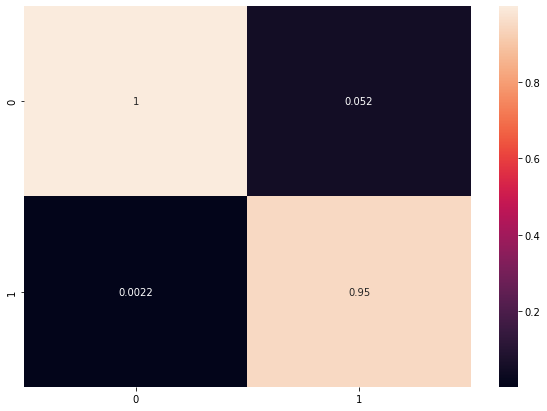

In [410]:
# Confusion Matrix creation


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
from sklearn.metrics import confusion_matrix

#Predict
y_prediction = model.predict(X_test)
y_prediction = np.where(y_prediction > 0.5, 1, 0)

result = confusion_matrix(y_test, y_prediction , normalize="pred")

plt.figure(figsize = (10,7))
sn.heatmap(result, annot=True)